# 1. データの取得  
ダウンロードしたipynbファイルとcsvファイルを自分のGoogleドライブに置く。

In [1]:
# Google-ColaboratoryからGoogleドライブにアクセスするためのおまじない。

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# csvファイルをダウンロード
import pandas as pd
# csvファイルをダウンロード
import pandas as pd

df = pd.read_csv('drive/My Drive/RNNによる為替予測/USDJPY.csv')
df

,datetime,open,high,low,close,volume
0,2005-05-07T21:00:00.000000000Z,105.145,105.165,105.075,105.125,254
1,2005-05-08T21:00:00.000000000Z,105.135,105.686,105.095,105.628,34018
2,2005-05-09T21:00:00.000000000Z,105.628,105.966,105.390,105.560,34363
3,2005-05-10T21:00:00.000000000Z,105.550,105.946,104.886,105.760,36765
4,2005-05-11T21:00:00.000000000Z,105.760,106.914,105.710,106.776,32469
...,...,...,...,...,...,...
4995,2022-01-26T22:00:00.000000000Z,114.650,115.489,114.476,115.362,85666
4996,2022-01-27T22:00:00.000000000Z,115.358,115.688,115.122,115.238,73707
4997,2022-01-30T22:00:00.000000000Z,115.296,115.592,114.923,115.136,70090
4998,2022-01-31T22:00:00.000000000Z,115.110,115.195,114.566,114.688,68569


# 2. データの加工
終値と流通量に追加で、ボラティリティと指数移動平均値を用いる。

In [ ]:
def processing_df(df):
  # 日時と時間のcolumnsを追加する
  df['ema_close'] = df['close'].ewm(span=5).mean()
  df['aoc_close'] = df['close'].diff(1)
  df['aoc_close'] = df['aoc_close'].fillna(df['aoc_close'].median())
  df['volume'] = df['volume']
  
  # columnsの位置を変更する
  df = df[['datetime', 'close', 'ema_close', 'aoc_close', 'volume']]
  return df

processing_df = processing_df(df)
processing_df

,datetime,close,ema_close,aoc_close,volume
0,2005-05-07T21:00:00.000000000Z,105.125,105.125000,0.000,254
1,2005-05-08T21:00:00.000000000Z,105.628,105.426800,0.503,34018
2,2005-05-09T21:00:00.000000000Z,105.560,105.489895,-0.068,34363
3,2005-05-10T21:00:00.000000000Z,105.760,105.602092,0.200,36765
4,2005-05-11T21:00:00.000000000Z,106.776,106.052739,1.016,32469
...,...,...,...,...,...
4995,2022-01-26T22:00:00.000000000Z,115.362,114.614911,0.681,85666
4996,2022-01-27T22:00:00.000000000Z,115.238,114.822607,-0.124,73707
4997,2022-01-30T22:00:00.000000000Z,115.136,114.927071,-0.102,70090
4998,2022-01-31T22:00:00.000000000Z,114.688,114.847381,-0.448,68569


# 3. データを可視化  
上から、'終値'、'終値のEMA', '終値の変化量', '終値の変化量のEWDF'をプロット。  
特に、'終値'と'終値の5日移動平均値'、 'ボラティリティ'と 'ボラティリティのEWDF'をそれぞれ比較して何のために、EMA、EWDFを求めたのかを考えてもらいたい。

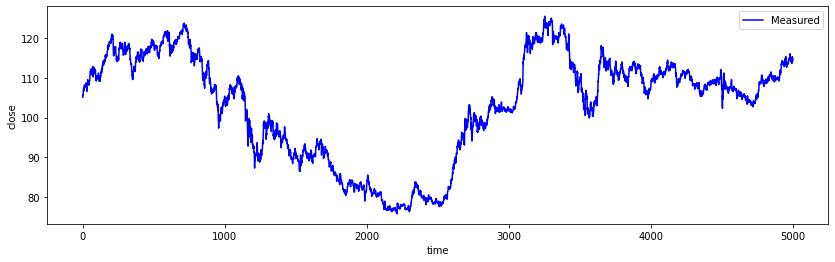

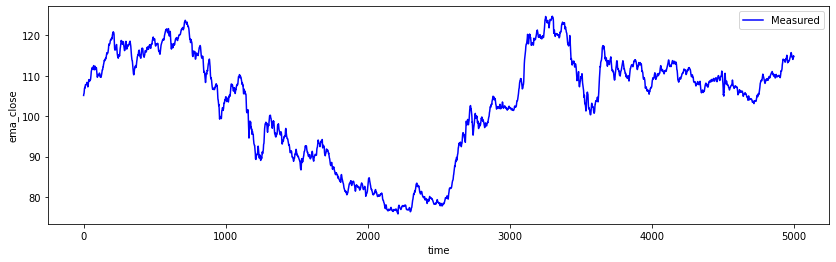

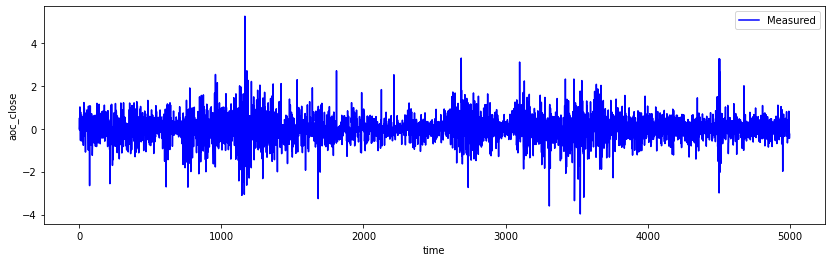

In [ ]:
from os import X_OK
import matplotlib.pyplot as plt

def show_graph(df, data ,label='close', color="b"):
  X_index = df.index.values
  X = data.values
  plt.figure(figsize=(14, 4))
  plt.xlabel('time')
  plt.ylabel(label)
  plt.plot(X_index, X, color=color, label='Measured')
  plt.legend(loc='upper right')
  plt.show()

show_graph(processing_df, processing_df['close'])
show_graph(processing_df, processing_df['ema_close'], 'ema_close')
show_graph(processing_df, processing_df['aoc_close'], 'aoc_close')

# 4. スケーリング

In [ ]:
# 正規化のためのライブラリ。
from sklearn.preprocessing import MinMaxScaler

def Normalization(data):
  data = pd.DataFrame(data)
  scaler = MinMaxScaler(feature_range=(-1, 1))
  data = scaler.fit_transform(data)
  return scaler, data

scaler, data = Normalization(df['ema_close'])

# 5. 訓練データと検証データとテストデータに分割  
モデルの精度を検証するためにはデータを**訓練データ**と**テストデータ**に分割する必要がある。

In [ ]:
# 70%で訓練、20%で検証、10%でテストする。

def split_train_valid_test(data):
  train, valid, test = data[0:int(len(data)*0.7),:], data[int(len(data)*0.7):int(len(data)*0.9),:], data[int(len(data)*0.9):,:]
  return train, valid, test

train, valid, test = split_train_valid_test(data)

# 6. モデルの検証

In [ ]:
# 必要なライブラリをインポート。
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# モデル学習のためのライブラリ
from tensorflow import keras
from tensorflow.keras.layers import LayerNormalization
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense

In [ ]:
# モデルの学習のためのパラメータを指定。

# ルックバック
# 過去どれくらいまで遡るかの指標。
# look_back=50の場合は現時点をtを予測するために[t-50, t-49, ... , t-1]までを用いる。
# look_back=50

# エポックサイズ
# モデルの学習回数。
epoch_size = 20

look_back=95
output = 5

# バッチサイズ
# モデルが1回の処理で使用する件数。
# 一般にbatch_sizeが大きい方が、計算速度が速くなる一方、精度は低下する。
batch_size=1

In [ ]:
def create_dataset(dataset, look_back, output):
  dataX, dataY = [], []
  # iは時間の数
  for i in range(len(dataset)-look_back-output+1):
    xset, yset = [], []
    for j in range(dataset.shape[1]):
      a = dataset[i:(i+look_back), j]
      xset.append(a)

    b = dataset[(i+look_back):(i+look_back)+output]
    yset.append(b)
    dataX.append(xset)
    dataY.append(yset)
  return np.array(dataX).reshape(len(dataX),look_back,1), np.array(dataY).reshape(len(dataY),output)

In [ ]:
def create_model(output):
    model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]), # 引数の数
    keras.layers.LSTM(20),
    keras.layers.Dense(output)
    ])
    
    model.compile(loss="mse", optimizer="adam")
    return model
model = create_model(output)

In [ ]:
def learning_model(train, valid, epoch_size):
    trainX, trainY = create_dataset(train, look_back, output)
    validX, validY = create_dataset(valid, look_back, output)
    history = model.fit(trainX, trainY, epochs=epoch_size, validation_data=(validX, validY))
    return trainX, trainY, validX, validY, history

trainX, trainY, validX, validY, history = learning_model(train, valid, epoch_size)

Epoch 1/20
107/107 [==============================] - 15s 95ms/step - loss: 0.0988 - val_loss: 0.0068
Epoch 2/20
107/107 [==============================] - 9s 81ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 3/20
107/107 [==============================] - 9s 82ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 4/20
107/107 [==============================] - 9s 82ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 5/20
107/107 [==============================] - 9s 83ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 6/20
107/107 [==============================] - 9s 81ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 7/20
107/107 [==============================] - 9s 86ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 8/20
107/107 [==============================] - 11s 99ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 9/20
107/107 [==============================] - 9s 81ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 10/20
107/107 [==============================] - 9s 82ms/step - loss: 0.0024 - val_

# 7. モデルの性能評価

In [ ]:
import math
from sklearn.metrics import mean_squared_error

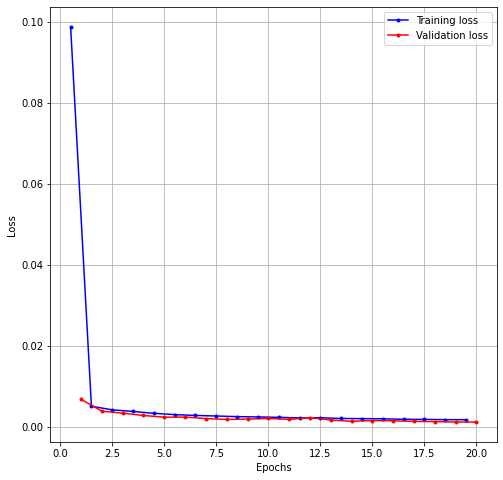

In [ ]:
# 各エポック毎の訓練誤差とテスト誤差を可視化。この結果はさすがにダメすぎる。訓練誤差が発散している。しいて言うならば、エポックサイズ14回が一番いい。

def plot_learning_curves(loss, val_loss):
    plt.figure(figsize=(8, 8))
    plt.plot(np.arange(len(loss)) + 0.5, loss, 'b.-', label='Training loss')
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, 'r.-', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()

plot_learning_curves(history.history["loss"], history.history["val_loss"])

In [ ]:
testX, testY = create_dataset(test, look_back, output)

def pad_array(val, pad_col):
    # 以下のnp.insertは配列pad_colのインデックス0番目の位置にxを挿入するという意味
    return np.array([np.insert(pad_col, 0, x) for x in val])

def reshape_dataset(dataset):
    dataset = dataset.reshape(len(dataset), -1)
    return dataset


def print_mse(model, trainX, trainY, validX, validY, testX, testY, scaler=False):
    # 10個前過去のデータ～1個前のデータまでを入力データとし、予測値を求める    
    trainPredict = model.predict(trainX)
    validPredict = model.predict(validX)
    testPredict = model.predict(testX)
    pad_col = np.zeros(data.shape[1]-1)

    # 標準化したデータを元に戻す
    if scaler == True:
      trainPredict = scaler.inverse_transform(pad_array(trainPredict, pad_col))
      trainY = scaler.inverse_transform(pad_array(trainY, pad_col))
      validPredict = scaler.inverse_transform(pad_array(validPredict, pad_col))
      validY = scaler.inverse_transform(pad_array(validY, pad_col))
      testPredict = scaler.inverse_transform(pad_array(testPredict, pad_col))
      testY = scaler.inverse_transform(pad_array(testY, pad_col))
    else:
      trainPredict = reshape_dataset(trainPredict)
      trainY = reshape_dataset(trainY)
      validPredict = reshape_dataset(validPredict)
      validY = reshape_dataset(validY)
      testPredict = reshape_dataset(testPredict)
      testY = reshape_dataset(testY)
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    validScore = math.sqrt(mean_squared_error(validY[:,0], validPredict[:,0]))
    print('Valid Score: %.2f RMSE' % (validScore))
    testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    return trainPredict, validPredict, testPredict

trainPredict, validPredict, testPredict = print_mse(model, trainX, trainY, validX, validY, testX, testY, scaler)

Train Score: 0.03 RMSE
Valid Score: 0.02 RMSE
Test Score: 0.02 RMSE


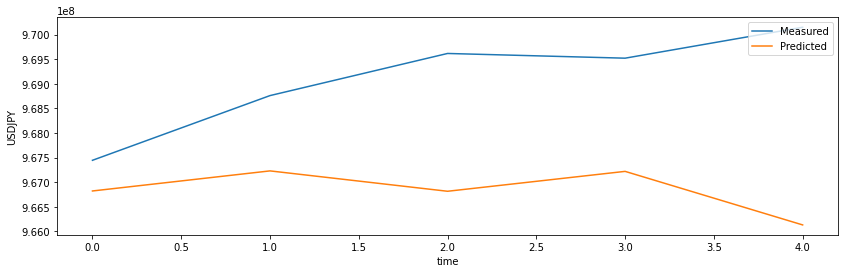

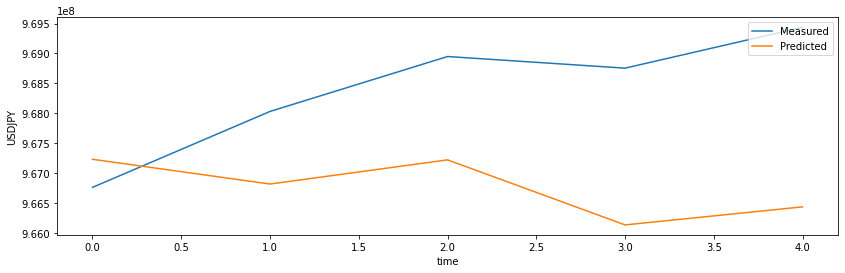

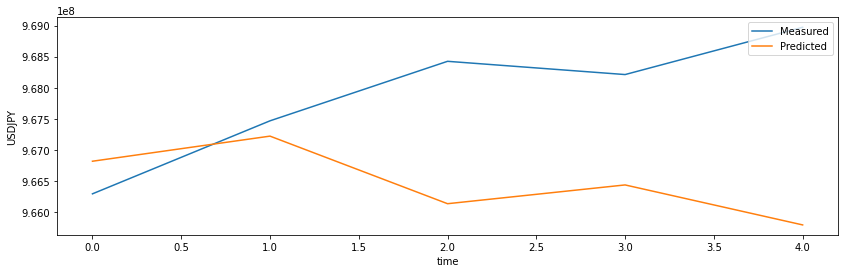

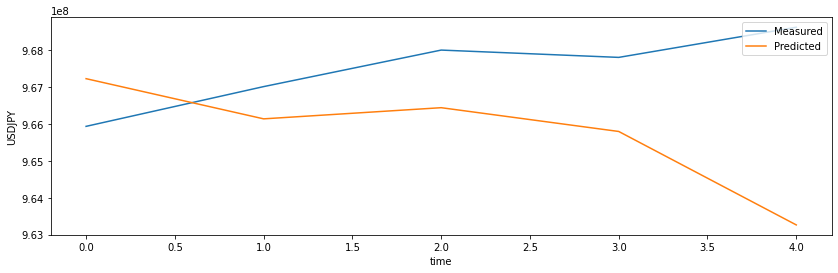

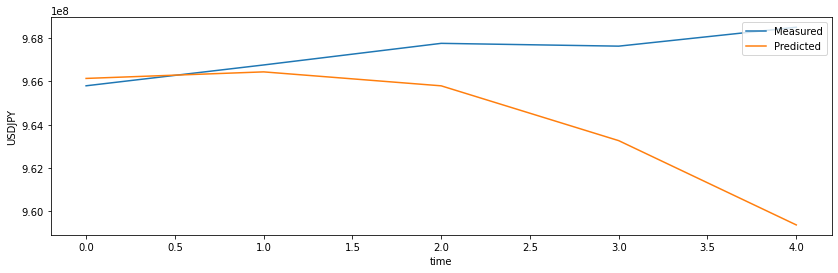

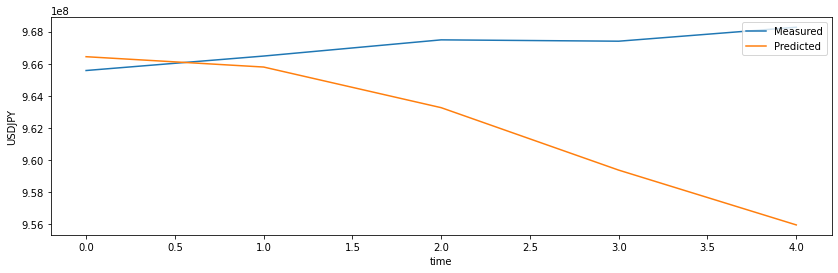

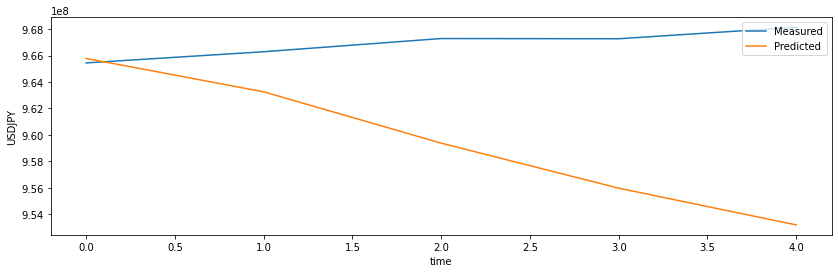

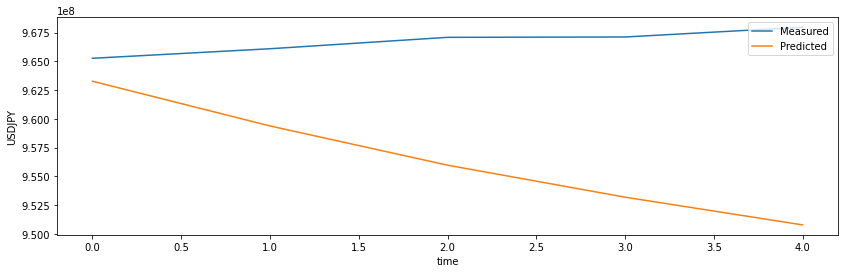

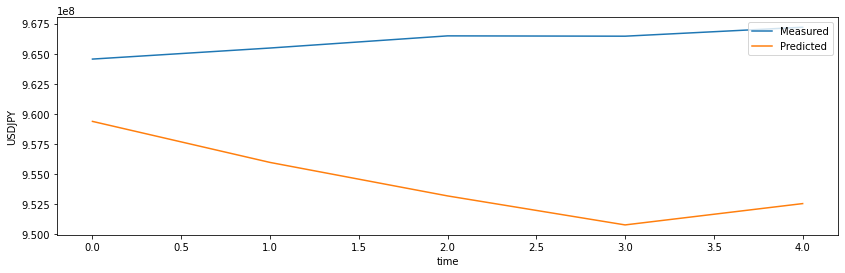

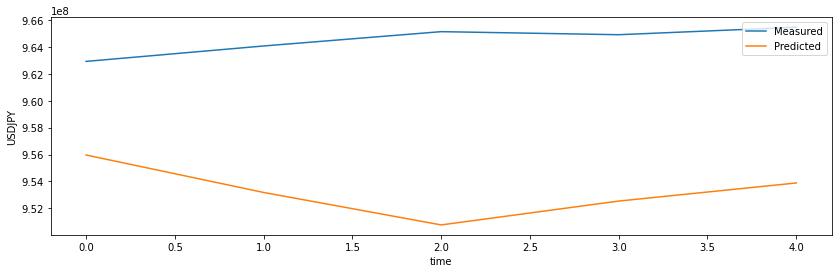

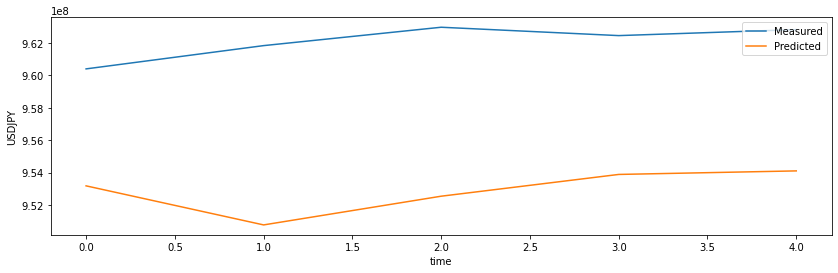

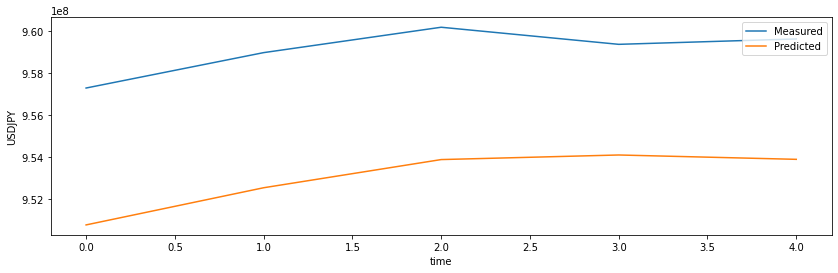

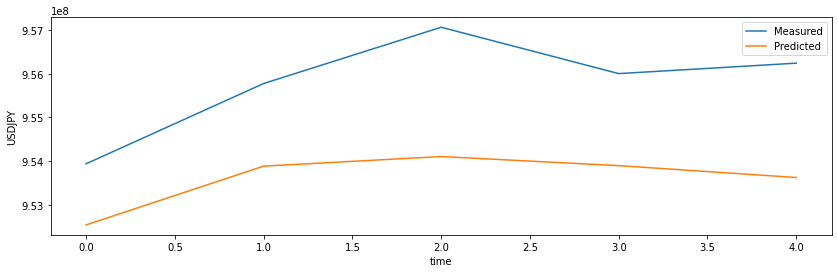

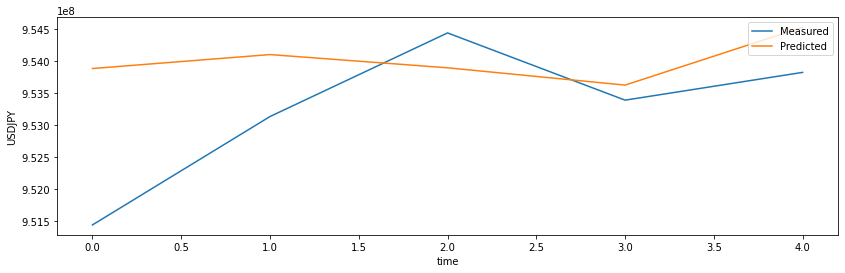

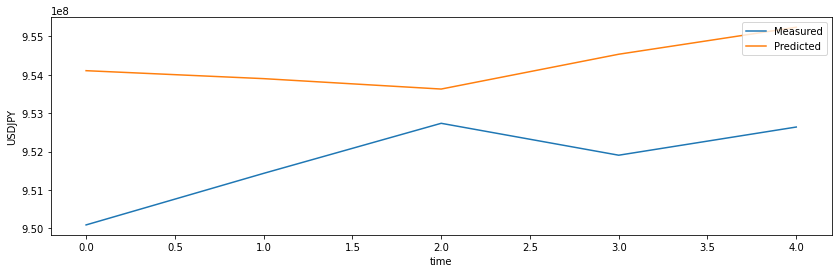

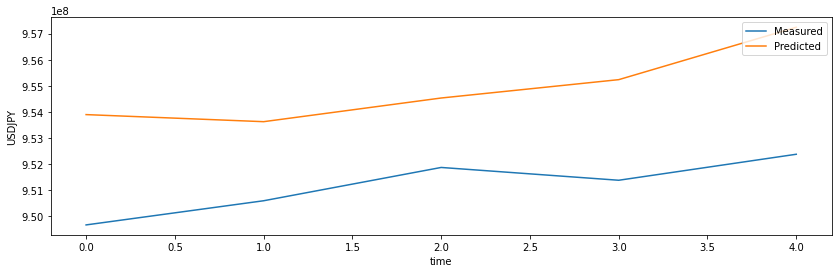

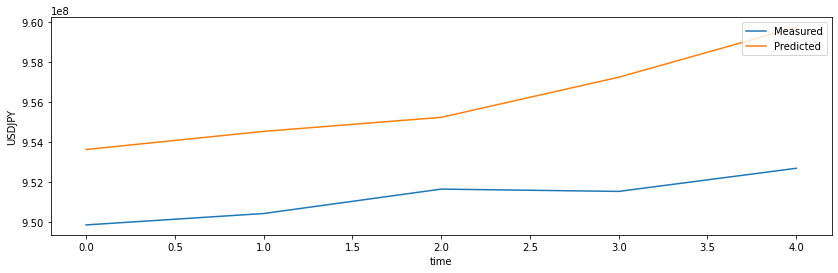

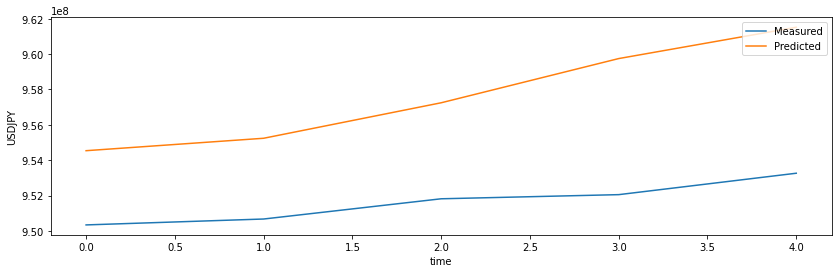

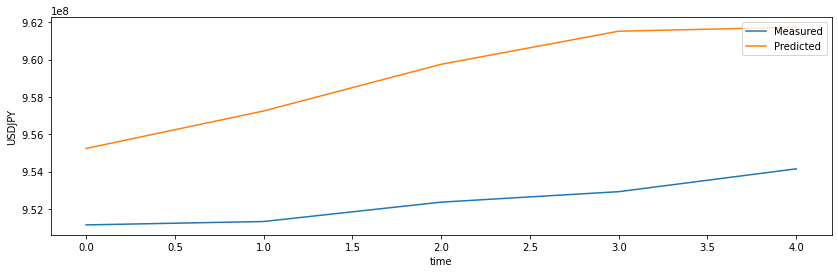

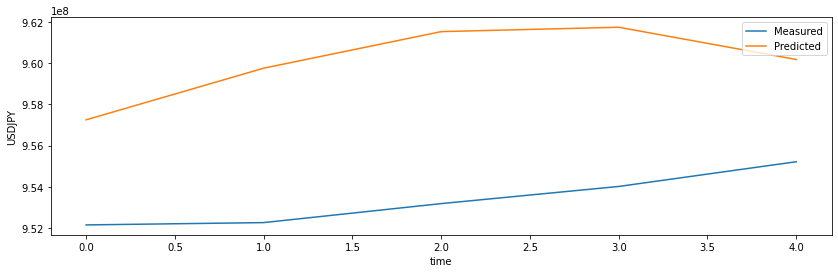

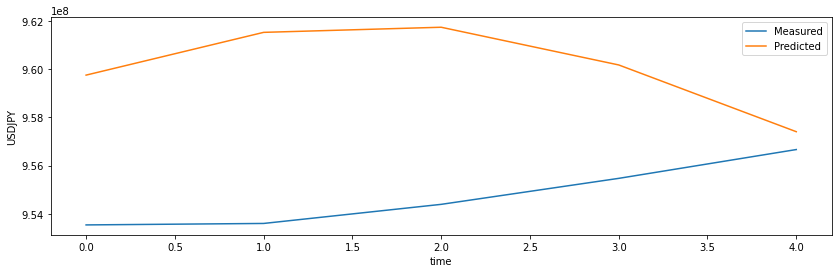

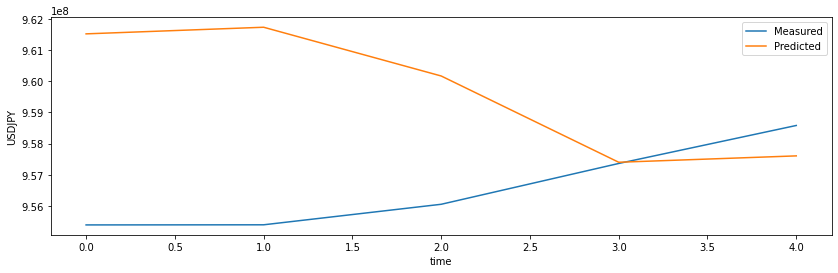

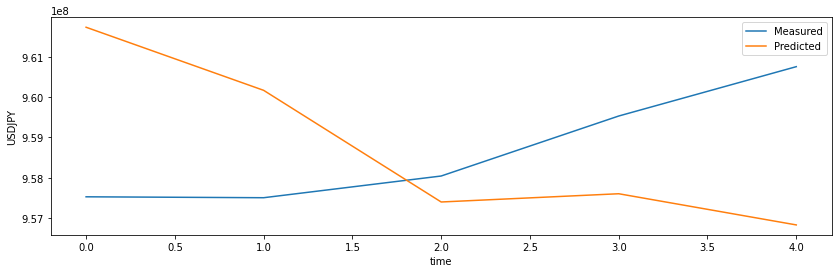

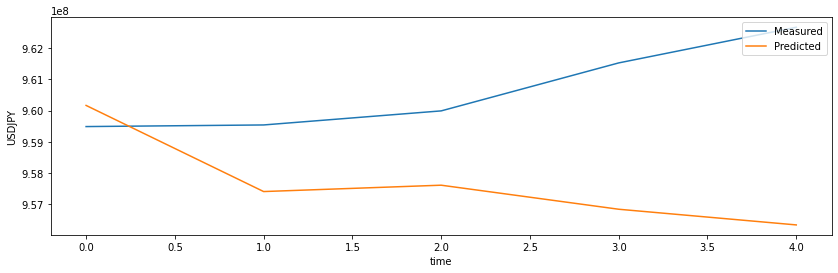

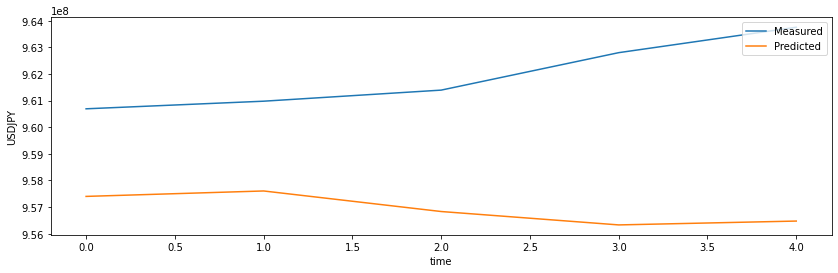

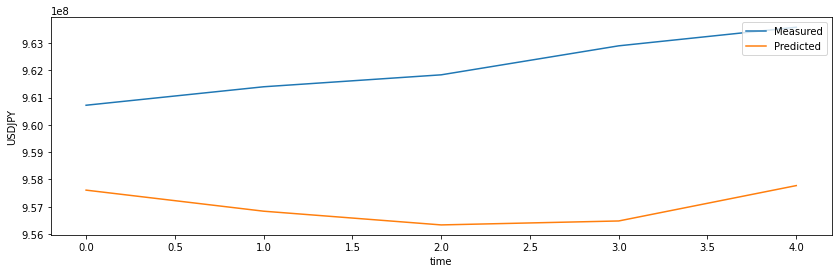

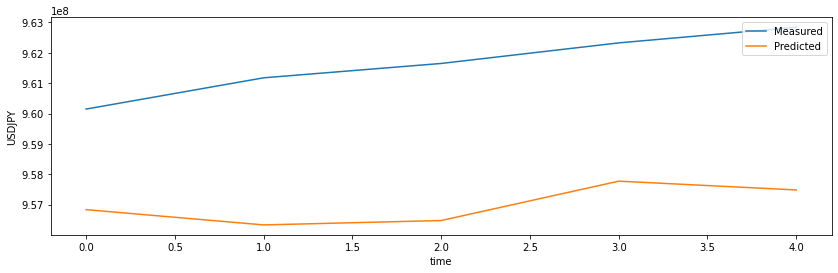

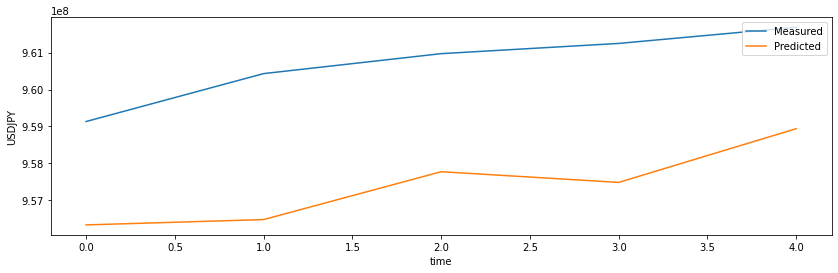

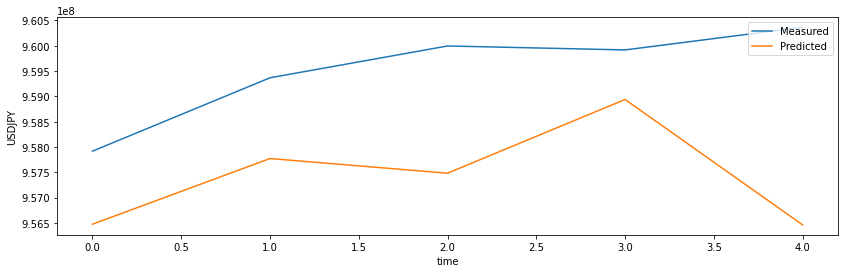

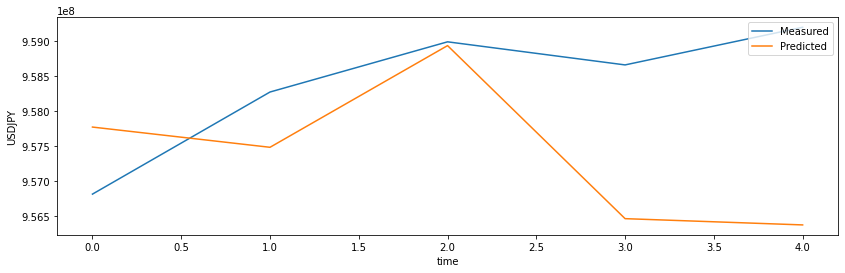

In [ ]:
def test_predictions_for_plotting(testPredict, testY, count):
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)
    correct = 0
    for i in range(count):
        plt.figure(figsize=(14, 4))
        plt.plot(testPredict[i], label='Measured')
        plt.plot(testY[i], label='Predicted')
        plt.legend(loc='upper right')
        plt.xlabel('time')
        plt.ylabel('USDJPY')
        plt.show()
        if (testPredict[i][4] - testPredict[i][0])*(testY[i][4] - testY[i][0]) > 0:
            correct += 1
    accurate = correct/count
    return accurate

accurate = test_predictions_for_plotting(testPredict, testY, 30)

In [ ]:
accurate

0.43333333333333335

Epoch 1/20
108/108 [==============================] - 10s 54ms/step - loss: 0.0565 - val_loss: 0.0040
Epoch 2/20
108/108 [==============================] - 6s 57ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 3/20
108/108 [==============================] - 7s 67ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 4/20
108/108 [==============================] - 5s 45ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 5/20
108/108 [==============================] - 5s 45ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 6/20
108/108 [==============================] - 5s 45ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 7/20
108/108 [==============================] - 6s 53ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 8/20
108/108 [==============================] - 7s 62ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 9/20
108/108 [==============================] - 5s 45ms/step - loss: 0.0014 - val_loss: 9.0555e-04
Epoch 10/20
108/108 [==============================] - 5s 45ms/step - loss: 0.0012 - v

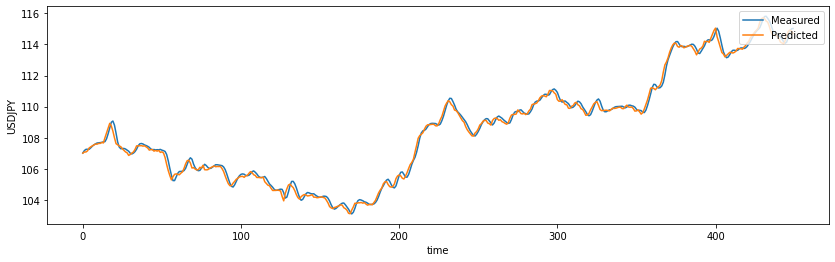

In [ ]:
# 1個先をプロットした場合。当たり前だけどうまく見えるに決まっている。
output = 1
model = create_model(output)
trainX, trainY, validX, validY, history = learning_model(train, valid, epoch_size)
trainPredict, validPredict, testPredict = print_mse(model, trainX, trainY, validX, validY, testX, testY, scaler)

def test_predictions_for_plotting(testPredict, testY):
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)
    plt.figure(figsize=(14, 4))
    plt.plot(testPredict, label='Measured')
    plt.plot(testY, label='Predicted')
    plt.legend(loc='upper right')
    plt.xlabel('time')
    plt.ylabel('USDJPY')
    plt.show()

test_predictions_for_plotting(testPredict, testY)